ZHVI dataset comes from https://www.kaggle.com/datasets/paultimothymooney/zillow-house-price-data?select=Sale_Prices_City.csv

Unemployment rate dataset comes from https://www.kaggle.com/datasets/axeltorbenson/unemployment-data-19482021

Inflation Rate(CPI) Dataset https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021

Interest rate dataset https://www.kaggle.com/datasets/raoofiali/us-interest-rate-weekly

GDP Growth Rate dataset https://www.kaggle.com/datasets/rajkumarpandey02/economy-of-the-united-states

In [1]:
#!pip install ydata-profiling
#!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import kagglehub
import math
import os
import warnings

#from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from IPython.display import clear_output, display, HTML

warnings.filterwarnings("ignore")
clear_output()

Adding Housing Data

In [2]:
# Download housing data
path = kagglehub.dataset_download("paultimothymooney/zillow-house-price-data")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

Files in the dataset:
/kaggle/input/zillow-house-price-data/Sale_Prices_State.csv
/kaggle/input/zillow-house-price-data/State_Zhvi_2bedroom.csv
/kaggle/input/zillow-house-price-data/DaysOnZillow_State.csv
/kaggle/input/zillow-house-price-data/State_MedianRentalPrice_Sfr.csv
/kaggle/input/zillow-house-price-data/City_Zhvi_SingleFamilyResidence.csv
/kaggle/input/zillow-house-price-data/State_Zri_SingleFamilyResidenlceRental.csv
/kaggle/input/zillow-house-price-data/City_Zri_SingleFamilyResidenceRental.csv
/kaggle/input/zillow-house-price-data/City_Zri_AllHomesPlusMultifamily.csv
/kaggle/input/zillow-house-price-data/State_Zhvi_3bedroom.csv
/kaggle/input/zillow-house-price-data/City_MedianRentalPrice_1Bedroom.csv
/kaggle/input/zillow-house-price-data/State_Zhvi_5BedroomOrMore.csv
/kaggle/input/zillow-house-price-data/State_MedianRentalPrice_Studio.csv
/kaggle/input/zillow-house-price-data/State_MedianRentalPrice_3Bedroom.csv
/kaggle/input/zillow-house-price-data/City_MedianRentalPrice_4Be

In [3]:
csv_path = os.path.join(path, "City_Zhvi_AllHomes.csv")
df = pd.read_csv(csv_path)
print(df.head())

   Unnamed: 0  RegionID  SizeRank   RegionName RegionType StateName State  \
0           0      6181         0     New York       City        NY    NY   
1           1     12447         1  Los Angeles       City        CA    CA   
2           2     39051         2      Houston       City        TX    TX   
3           3     17426         3      Chicago       City        IL    IL   
4           4      6915         4  San Antonio       City        TX    TX   

                              Metro          CountyName  1996-01-31  ...  \
0       New York-Newark-Jersey City       Queens County    196258.0  ...   
1    Los Angeles-Long Beach-Anaheim  Los Angeles County    185649.0  ...   
2  Houston-The Woodlands-Sugar Land       Harris County     93518.0  ...   
3          Chicago-Naperville-Elgin         Cook County    130920.0  ...   
4         San Antonio-New Braunfels        Bexar County     94041.0  ...   

   2019-06-30  2019-07-31  2019-08-31  2019-09-30  2019-10-31  2019-11-30  \
0  

In [4]:
# remove rows with NaN
df_cleaned = df.dropna()
print("DataFrame after removing rows with any NaN values:")
print(df_cleaned.head())
data = df_cleaned

DataFrame after removing rows with any NaN values:
   Unnamed: 0  RegionID  SizeRank   RegionName RegionType StateName State  \
0           0      6181         0     New York       City        NY    NY   
1           1     12447         1  Los Angeles       City        CA    CA   
2           2     39051         2      Houston       City        TX    TX   
3           3     17426         3      Chicago       City        IL    IL   
4           4      6915         4  San Antonio       City        TX    TX   

                              Metro          CountyName  1996-01-31  ...  \
0       New York-Newark-Jersey City       Queens County    196258.0  ...   
1    Los Angeles-Long Beach-Anaheim  Los Angeles County    185649.0  ...   
2  Houston-The Woodlands-Sugar Land       Harris County     93518.0  ...   
3          Chicago-Naperville-Elgin         Cook County    130920.0  ...   
4         San Antonio-New Braunfels        Bexar County     94041.0  ...   

   2019-06-30  2019-07-31  20

In [5]:
# Remove location identifier since only one city has data for each month/year
data.drop('State',axis=1,inplace=True)
data.drop('CountyName',axis=1,inplace=True)
data.drop('SizeRank',axis=1,inplace=True)
data.drop('Metro',axis=1,inplace=True)
data.drop('Unnamed: 0',axis=1,inplace=True)
data.drop('RegionID',axis=1,inplace=True)
data.drop('RegionType',axis=1,inplace=True)
data.drop('StateName',axis=1,inplace=True)
data = data.reset_index(drop=True)

# Select single city (New York)
data = data[data['RegionName']=='New York']
data.drop('RegionName',axis=1,inplace=True)
print(data)

   1996-01-31  1996-02-29  1996-03-31  1996-04-30  1996-05-31  1996-06-30  \
0    196258.0    195693.0    195383.0    194836.0    194652.0    194520.0   

   1996-07-31  1996-08-31  1996-09-30  1996-10-31  ...  2019-06-30  \
0    194447.0    194313.0    194271.0    194341.0  ...    659421.0   

   2019-07-31  2019-08-31  2019-09-30  2019-10-31  2019-11-30  2019-12-31  \
0    659007.0    658239.0    656925.0    655613.0    654394.0    653930.0   

   2020-01-31  2020-02-29  2020-03-31  
0    653901.0    653565.0    652307.0  

[1 rows x 291 columns]


Adding Interest Rate Data

In [6]:
path = kagglehub.dataset_download("raoofiali/us-interest-rate-weekly")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

xlsx_path = os.path.join(path, "Us-Interest Rate-Weekly.xlsx")
ir_df = pd.read_excel(xlsx_path)
ir_df.drop('Unnamed: 0',axis=1,inplace=True)
print(ir_df.head())
print(ir_df.tail())

Files in the dataset:
/kaggle/input/us-interest-rate-weekly/Us-Interest Rate-Weekly.xlsx
         Date  Value
0  1971-08-04   5.50
1  1971-08-15   5.50
2  1971-08-16   5.75
3  1971-08-31   5.75
4  1971-09-01   5.13
            Date  Value
1678  2024-02-29    5.5
1679  2024-03-19    5.5
1680  2024-03-20    5.5
1681  2024-04-30    5.5
1682  2024-05-01    5.5


In [7]:
# convert date format
ir_df['Date'] = pd.to_datetime(ir_df['Date'])

# Filter to include only rows between January 1996 and March 2020 to match housing data
start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2020-03-31')
filtered_ir_df = ir_df[(ir_df['Date'] >= start_date) & (ir_df['Date'] <= end_date)]

# Resample the data to get the monthly average
ir_df = filtered_ir_df.resample('M', on='Date').mean().reset_index()

# create time index
ir_df['Year'] = ir_df['Date'].dt.year
ir_df['Month'] = ir_df['Date'].dt.month
ir_df['TimeIndex'] = (ir_df['Year'] - ir_df['Year'].min()) * 12 + (ir_df['Month'] - ir_df['Month'].min())
ir_df.drop('Date',axis=1,inplace=True)

print(ir_df.head())
print(ir_df.tail())

   Value  Year  Month  TimeIndex
0  5.375  1996      1          0
1  5.250  1996      2          1
2  5.250  1996      3          2
3  5.250  1996      4          3
4  5.250  1996      5          4
     Value  Year  Month  TimeIndex
286  1.750  2019     11        286
287  1.750  2019     12        287
288  1.750  2020      1        288
289  1.750  2020      2        289
290  1.125  2020      3        290


Adding Inflation Rate Data

In [8]:
path = kagglehub.dataset_download("varpit94/us-inflation-data-updated-till-may-2021")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

csv_path = os.path.join(path, "US CPI.csv")
cpi_df = pd.read_csv(csv_path)

print(cpi_df.head())
print(cpi_df.tail())

Files in the dataset:
/kaggle/input/us-inflation-data-updated-till-may-2021/US CPI.csv
      Yearmon  CPI
0  01-01-1913  9.8
1  01-02-1913  9.8
2  01-03-1913  9.8
3  01-04-1913  9.8
4  01-05-1913  9.7
         Yearmon      CPI
1298  01-03-2021  264.877
1299  01-04-2021  267.054
1300  01-05-2021  269.195
1301  01-06-2021  271.696
1302  01-07-2021  273.003


In [9]:
cpi_df['Yearmon'] = pd.to_datetime(cpi_df['Yearmon'], format='%d-%m-%Y')

start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2020-03-31')
filtered_cpi_df = cpi_df[(cpi_df['Yearmon'] >= start_date) & (cpi_df['Yearmon'] <= end_date)]
filtered_cpi_df = filtered_cpi_df.reset_index(drop=True)

filtered_cpi_df['Year'] = filtered_cpi_df['Yearmon'].dt.year
filtered_cpi_df['Month'] = filtered_cpi_df['Yearmon'].dt.month
filtered_cpi_df['TimeIndex'] = (filtered_cpi_df['Year'] - filtered_cpi_df['Year'].min()) * 12 + (filtered_cpi_df['Month'] - filtered_cpi_df['Month'].min())
filtered_cpi_df = filtered_cpi_df.reset_index(drop=True)

print(filtered_cpi_df)

       Yearmon      CPI  Year  Month  TimeIndex
0   1996-01-01  154.400  1996      1          0
1   1996-02-01  154.900  1996      2          1
2   1996-03-01  155.700  1996      3          2
3   1996-04-01  156.300  1996      4          3
4   1996-05-01  156.600  1996      5          4
..         ...      ...   ...    ...        ...
286 2019-11-01  257.208  2019     11        286
287 2019-12-01  256.974  2019     12        287
288 2020-01-01  257.971  2020      1        288
289 2020-02-01  258.678  2020      2        289
290 2020-03-01  258.115  2020      3        290

[291 rows x 5 columns]


Adding Unemployment rate data

In [10]:
# download unemployment rate data
path = kagglehub.dataset_download("axeltorbenson/unemployment-data-19482021")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

# Load CSV file
csv_path = os.path.join(path, "unemployment_rate_data.csv")
un_df = pd.read_csv(csv_path)

print(un_df.head())
print(un_df.tail())

Files in the dataset:
/kaggle/input/unemployment-data-19482021/unemployment_rate_data.csv
       date  unrate  unrate_men  unrate_women  unrate_16_to_17  \
0  1/1/1948     4.0         4.2           3.5             10.8   
1  2/1/1948     4.7         4.7           4.8             15.0   
2  3/1/1948     4.5         4.5           4.4             13.2   
3  4/1/1948     4.0         4.0           4.1              9.9   
4  5/1/1948     3.4         3.3           3.4              6.4   

   unrate_18_to_19  unrate_20_to_24  unrate_25_to_34  unrate_35_to_44  \
0              9.6              6.6              3.6              2.6   
1              9.5              8.0              4.0              3.2   
2              9.3              8.6              3.5              3.2   
3              8.1              6.8              3.5              3.1   
4              7.2              6.3              2.8              2.5   

   unrate_45_to_54  unrate_55_over  
0              2.7             3.6  


In [11]:
# select same range of dates of housing data and only the overall unemployment rate
un_df = un_df.iloc[576:576+291][['unrate','date']]
un_df = un_df.reset_index(drop=True)

# Convert the date column to get specific year and month feature
un_df['date'] = pd.to_datetime(un_df['date'])
un_df['Year'] = un_df['date'].dt.year
un_df['Month'] = un_df['date'].dt.month
un_df['TimeIndex'] = (un_df['Year'] - un_df['Year'].min()) * 12 + (un_df['Month'] - un_df['Month'].min())
un_df.drop('date',axis=1,inplace=True)

Adding GDP Growth %

In [12]:
# Download data
path = kagglehub.dataset_download("rajkumarpandey02/economy-of-the-united-states")

print("Path to dataset files:", path)

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

csv_path = os.path.join(path, "Economy of the United States.csv")
gdp_df = pd.read_csv(csv_path)

print(gdp_df.head())
print(gdp_df.tail())

Path to dataset files: /kaggle/input/economy-of-the-united-states
Files in the dataset:
/kaggle/input/economy-of-the-united-states/Economy of the United States.csv
   Unnamed: 0  Year  GDP (in Bil. US$PPP)  GDP per capita (in US$ PPP)  \
0           0  1980                2857.3                      12552.9   
1           1  1981                3207.0                      13948.7   
2           2  1982                3343.8                      14405.0   
3           3  1983                3634.0                      15513.7   
4           4  1984                4037.7                      17086.4   

   GDP (in Bil. US$nominal)  GDP per capita (in US$ nominal)  \
0                    2857.3                          12552.9   
1                    3207.0                          13948.7   
2                    3343.8                          14405.0   
3                    3634.0                          15513.7   
4                    4037.7                          17086.4   

  GDP 

In [13]:
gdp_df = gdp_df[gdp_df['Year'] >= 1996]
gdp_df = gdp_df[gdp_df['Year'] <= 2020]
gdp_df = gdp_df.reset_index(drop=True)
gdp_df = gdp_df[['Year','GDP growth (real)']]

gdp_df['GDP growth (real)'] = gdp_df['GDP growth (real)'].str.replace('%', '')
gdp_df['GDP Growth'] = pd.to_numeric(gdp_df['GDP growth (real)'])
gdp_df.drop('GDP growth (real)',axis=1,inplace=True)

# add instance for each month
gdp_df = gdp_df.loc[gdp_df.index.repeat(12)].reset_index(drop=True)
gdp_df['Month'] = (gdp_df.groupby('Year').cumcount() % 12) + 1
gdp_df = gdp_df.iloc[:-9]

print(gdp_df.head())
print(gdp_df.tail())

   Year  GDP Growth  Month
0  1996         3.8      1
1  1996         3.8      2
2  1996         3.8      3
3  1996         3.8      4
4  1996         3.8      5
     Year  GDP Growth  Month
286  2019         2.3     11
287  2019         2.3     12
288  2020        -3.4      1
289  2020        -3.4      2
290  2020        -3.4      3


In [14]:
# reshape data to have rows correspond to each time, with features being the time, price, and unemployment rate
reshaped_data = []

# Loop through each column to get feature dates
for column in data.columns:
  year, month,day = map(int, column.split('-'))

  # Loop through each row to get price for the current date
  for index, row in data.iterrows():
   zhvi = row[column]

   reshaped_data.append({
      'ZHVI': zhvi,
      'Year': year,
      'Month': month,
      'Year-Month': f'{year}-{month}'
      })

reshaped_df = pd.DataFrame(reshaped_data)

# Add a time index
reshaped_df['TimeIndex'] = (reshaped_df['Year'] - reshaped_df['Year'].min()) * 12 + (reshaped_df['Month'] - reshaped_df['Month'].min())

# Sort data by month/year
full_df = reshaped_df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
full_df['Unemployment Rate'] = un_df['unrate']
full_df['CPI'] = filtered_cpi_df['CPI']
full_df['Interest Rate'] = ir_df['Value']
full_df['GDP Growth'] = gdp_df['GDP Growth']
print("Reshaped DataFrame:")
print(full_df)

Reshaped DataFrame:
         ZHVI  Year  Month Year-Month  TimeIndex  Unemployment Rate      CPI  \
0    196258.0  1996      1     1996-1          0                6.3  154.400   
1    195693.0  1996      2     1996-2          1                6.0  154.900   
2    195383.0  1996      3     1996-3          2                5.8  155.700   
3    194836.0  1996      4     1996-4          3                5.4  156.300   
4    194652.0  1996      5     1996-5          4                5.4  156.600   
..        ...   ...    ...        ...        ...                ...      ...   
286  654394.0  2019     11    2019-11        286                3.3  257.208   
287  653930.0  2019     12    2019-12        287                3.4  256.974   
288  653901.0  2020      1     2020-1        288                4.0  257.971   
289  653565.0  2020      2     2020-2        289                3.8  258.678   
290  652307.0  2020      3     2020-3        290                4.5  258.115   

     Interest Rate 

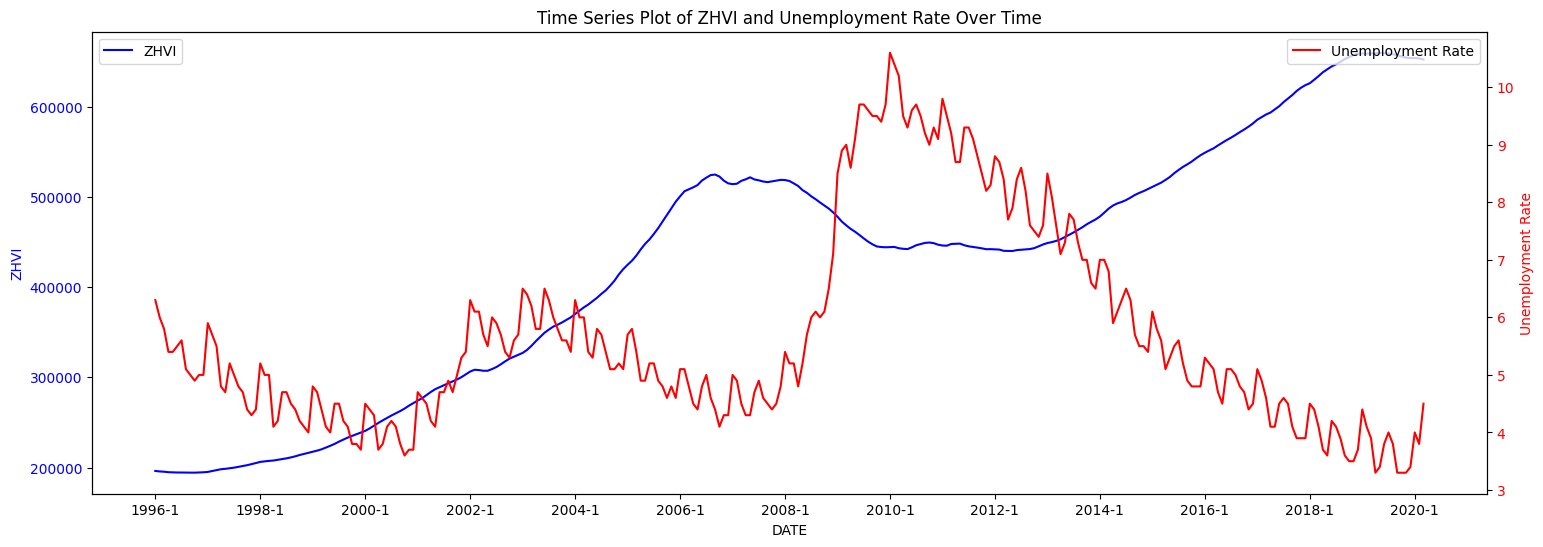

In [15]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(un_df['TimeIndex'], un_df['unrate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and Unemployment Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

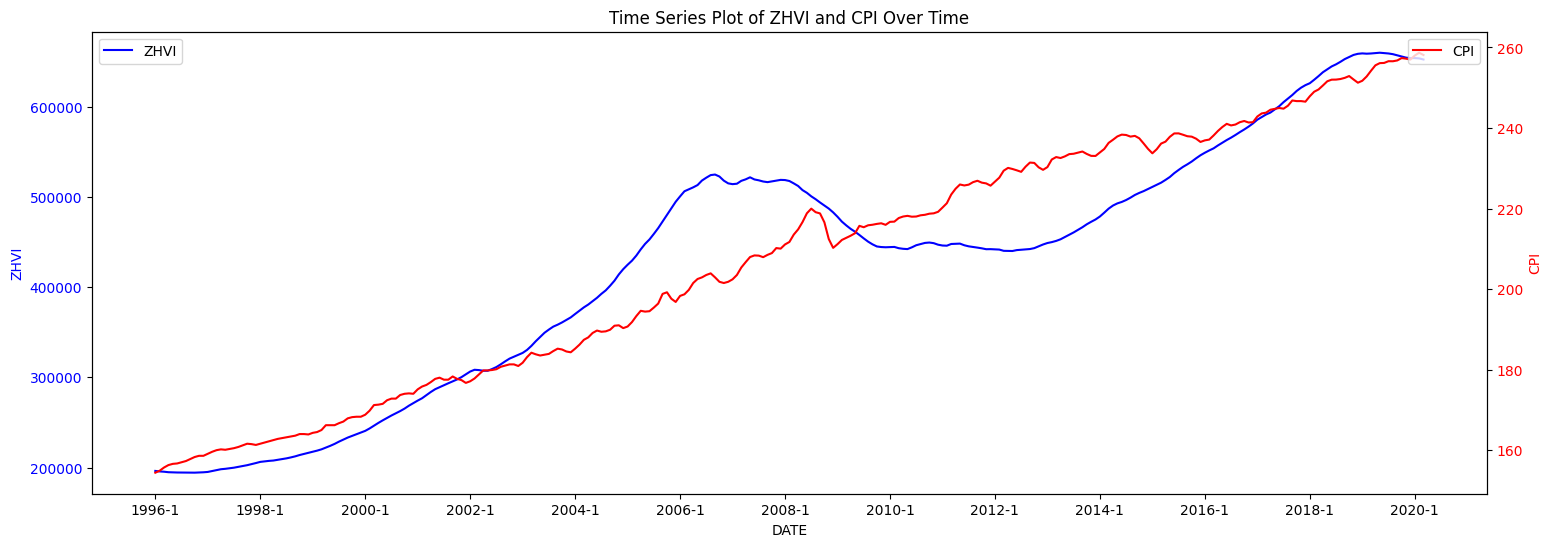

In [16]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(filtered_cpi_df['TimeIndex'], filtered_cpi_df['CPI'], color='red', label='CPI')
ax2.set_ylabel('CPI', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and CPI Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

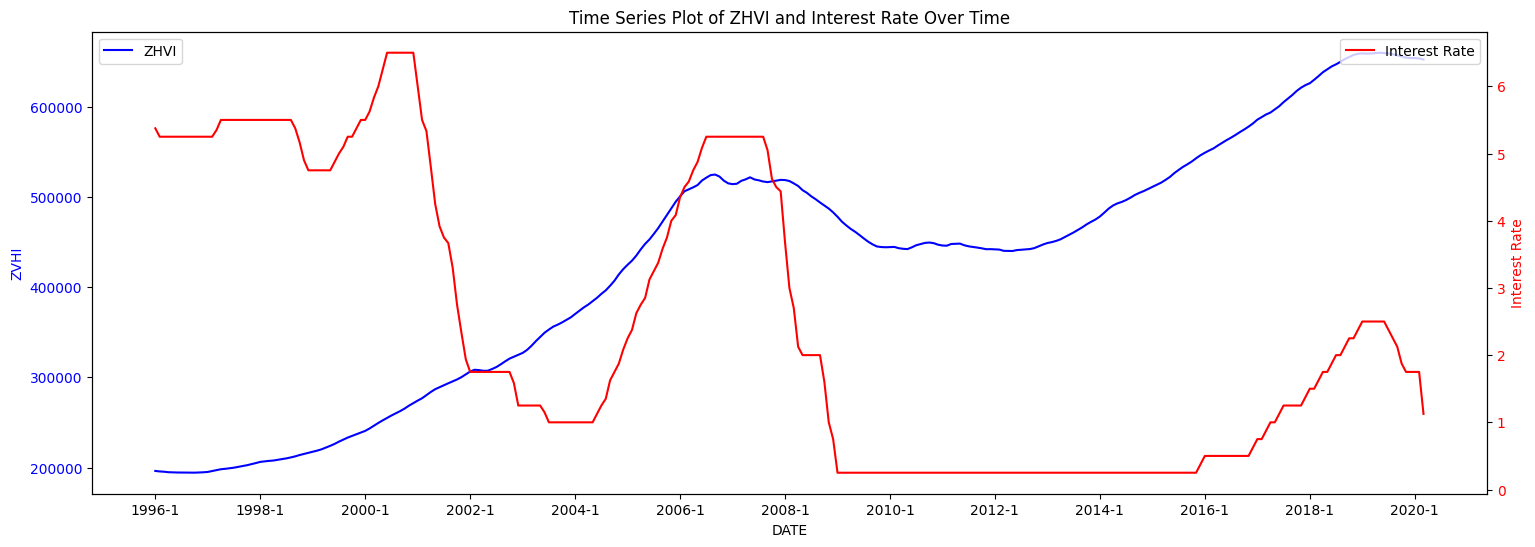

In [17]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZVHI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(ir_df['TimeIndex'], ir_df['Value'], color='red', label='Interest Rate')
ax2.set_ylabel('Interest Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and Interest Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

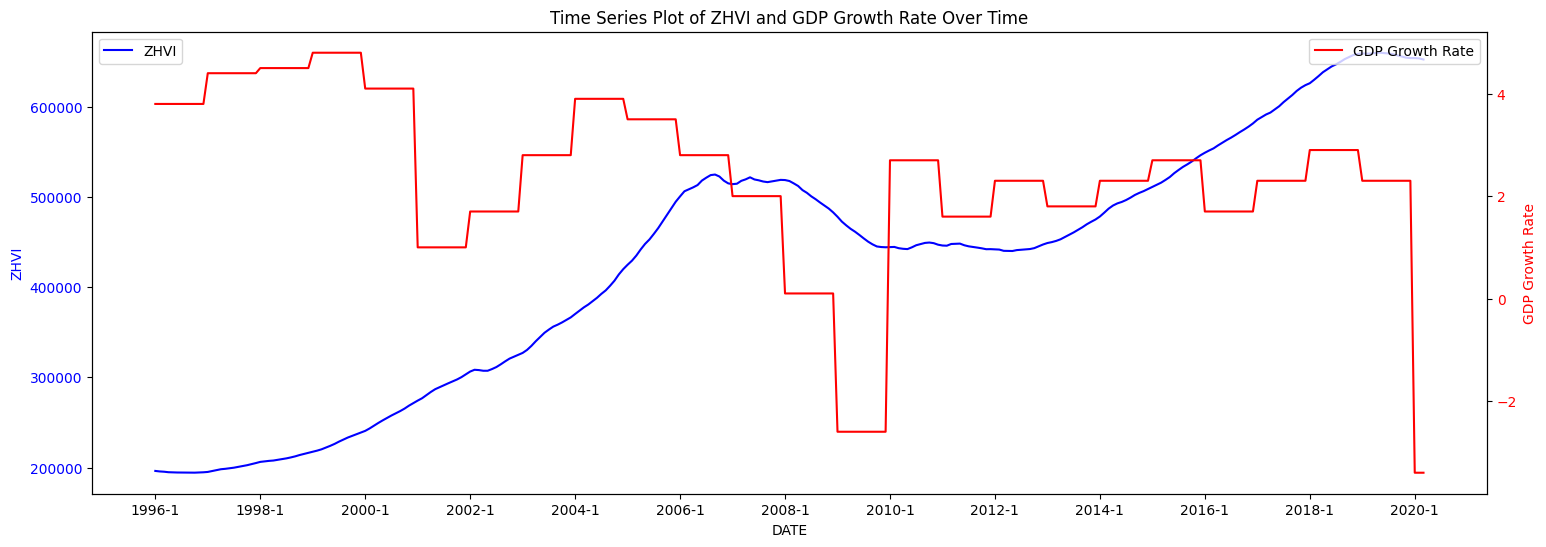

In [18]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(ir_df['TimeIndex'], gdp_df['GDP Growth'], color='red', label='GDP Growth Rate')
ax2.set_ylabel('GDP Growth Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and GDP Growth Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

OLS Model

OLS Root Mean Squared Error (RMSE): 130532.09645357582
OLS Mean Absolute Percentage Error(MAPE): 0.1853761687014548
OLS Mean Absolute Error(MAE): 112483.27602848076
OLS R-squared(R^2): -0.14393633055157418


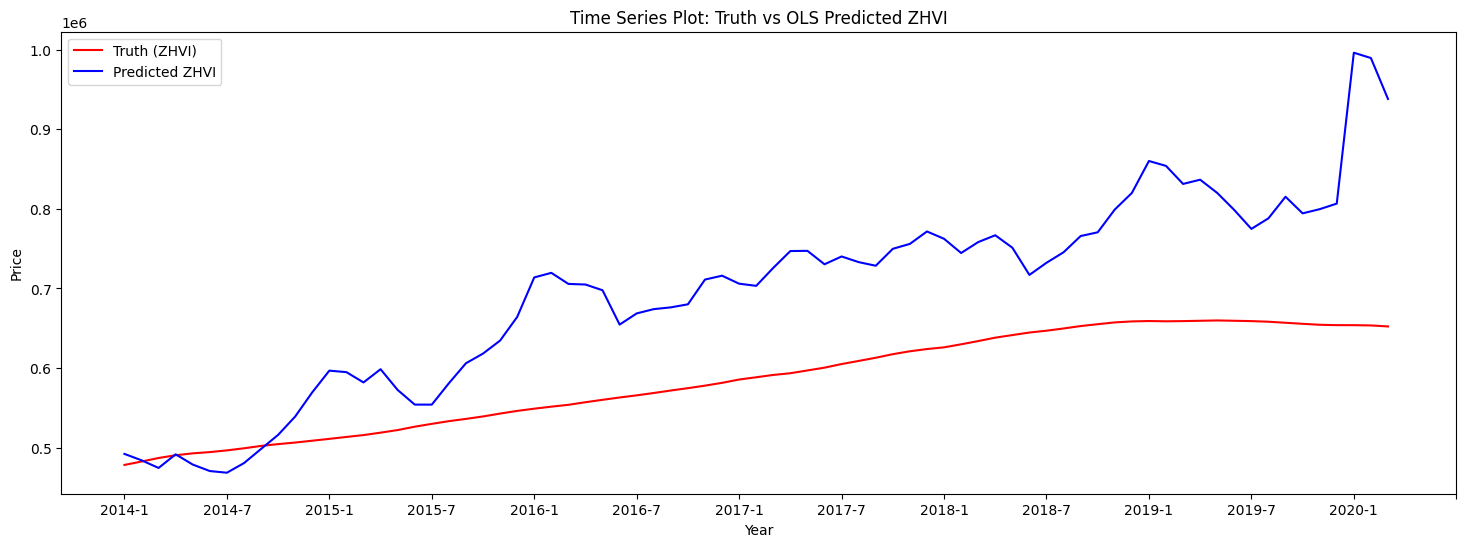

In [19]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

# Prediction test
X_test = test[['Year', 'Month', 'TimeIndex','Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# add constant
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fit OLS model
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

predictions = results.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
OLS_pred = test['Predicted_ZHVI']

# model evaluation
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"OLS Root Mean Squared Error (RMSE): {rmse}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print("OLS Mean Absolute Percentage Error(MAPE):", mape)
MAE = mean_absolute_error(y_test, y_pred)
print("OLS Mean Absolute Error(MAE):", MAE)
r2 = r2_score(y_pred,y_test)
print(f"OLS R-squared(R^2): {r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Year')
plt.ylabel('Price')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs OLS Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 OLS Regression Coefficients:
                   Feature   Coefficient  Absolute_Coefficient
x24          TimeIndex CPI -7.053306e+06          7.053306e+06
x31                  CPI^2  4.083916e+06          4.083916e+06
x13               Year CPI -1.580288e+06          1.580288e+06
x22            TimeIndex^2  1.550302e+06          1.550302e+06
x6                     CPI -1.441312e+06          1.441312e+06
x11         Year TimeIndex  1.185220e+06          1.185220e+06
x9                  Year^2  1.183376e+06          1.183376e+06
x2                    Year  1.181150e+06          1.181150e+06
x4               TimeIndex  1.181129e+06          1.181129e+06
x28  Unemployment Rate CPI  7.756565e+05          7.756565e+05


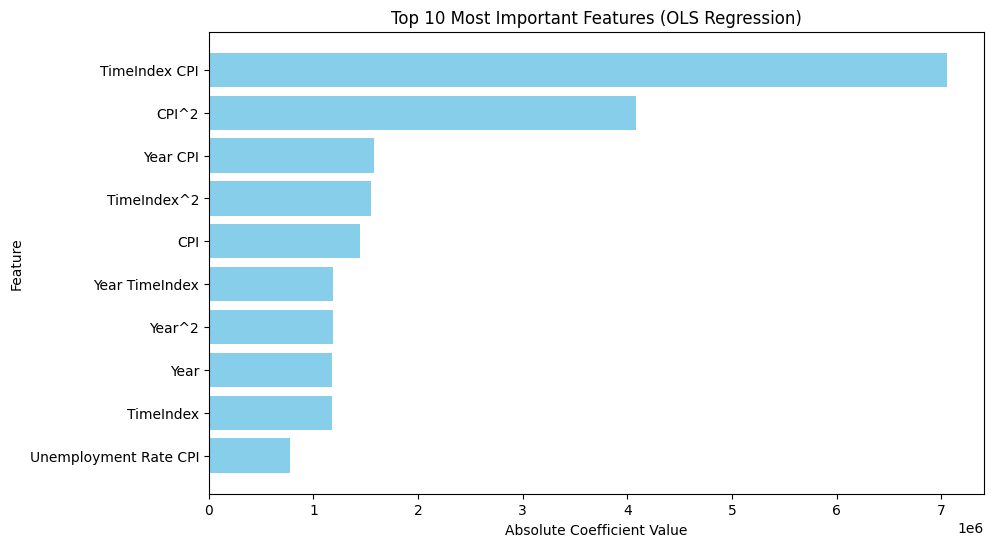

In [20]:
# Get feature names
feature_names = ['const'] + list(poly.get_feature_names_out(X_train.columns))

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': results.params
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 OLS Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (OLS Regression)')
plt.gca().invert_yaxis()
plt.show()

Lasso Regression Model

Lowest MAPE: 0.05492470799176251
Lowest Alpha: 50


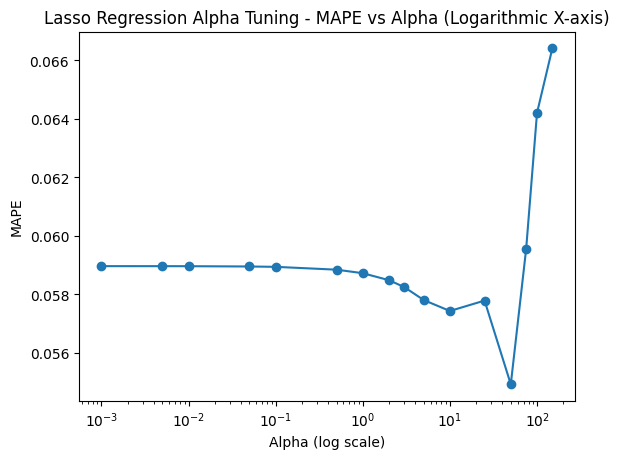



Lasso Root Mean Squared Error (RMSE): 44618.016149679155
Lasso Mean Absolute Percentage Error (MAPE): 0.05492470799176251
Mean Absolute Error (MAE): 34030.374729689334
R-squared(R^2): 0.7853309788737721


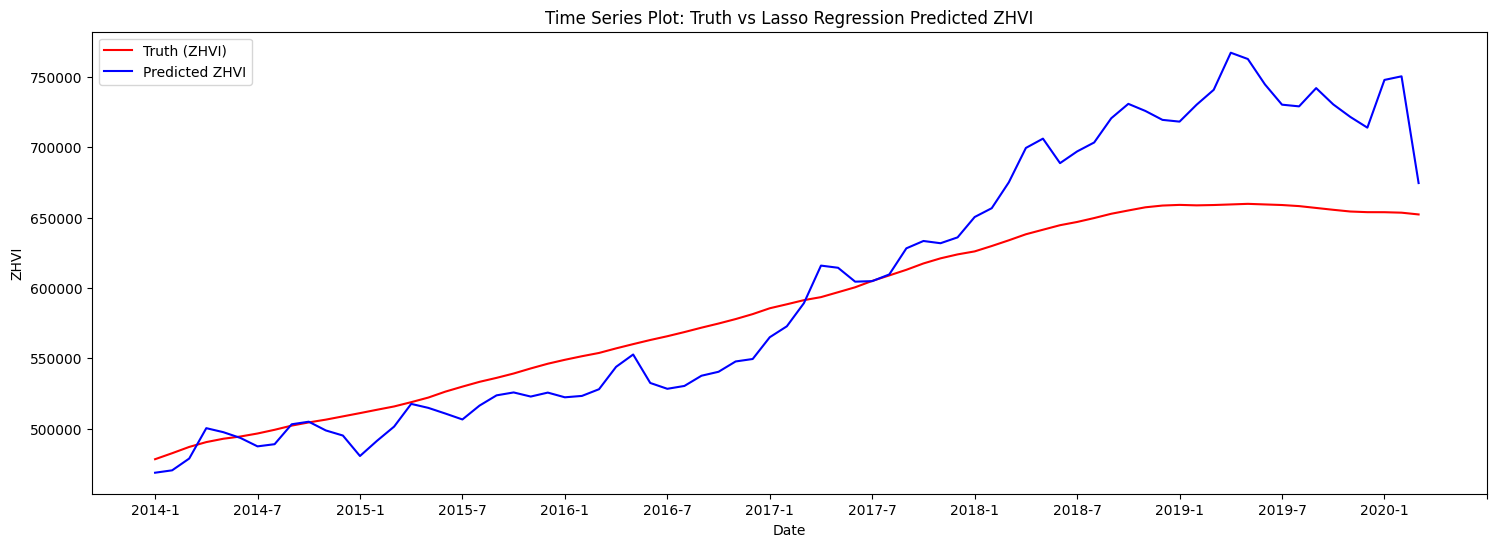

In [21]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

# Prepare test data for prediction
X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Fit Lasso regression model
alphas = [0.001,0.005,0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10,25,50,75,100,150]
results = []
lowest_alpha = alphas[0]
lowest_mape = float('inf')

for alpha in alphas:
  lasso_model = Lasso(alpha=alpha)
  lasso_model.fit(X_train_scaled, y_train)

  # Predict
  predictions = lasso_model.predict(X_test_scaled)
  test['Predicted_ZHVI'] = predictions

  # Model evaluation
  y_test = test['ZHVI']
  y_pred = test['Predicted_ZHVI']
  lasso_pred = test['Predicted_ZHVI']

  mape = mean_absolute_percentage_error(y_test, y_pred)
  results.append(mape)
  if mape < lowest_mape:
    lowest_mape = mape
    lowest_alpha = alpha

print("Lowest MAPE:", lowest_mape)
print("Lowest Alpha:", lowest_alpha)

# Plot hyperparameter tuning
plt.plot(alphas, results, marker='o')
plt.xscale('log')

plt.xlabel('Alpha (log scale)')
plt.ylabel('MAPE')
plt.title('Lasso Regression Alpha Tuning - MAPE vs Alpha (Logarithmic X-axis)')

plt.show()

alpha = lowest_alpha

lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)

# Predict
predictions = lasso_model.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

# Model evaluation
y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
lasso_pred = test['Predicted_ZHVI']

lasso_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n\nLasso Root Mean Squared Error (RMSE): {lasso_rmse}")
lasso_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Lasso Mean Absolute Percentage Error (MAPE):", lasso_mape)
lasso_MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", lasso_MAE)
lasso_r2 = r2_score(y_pred,y_test)
print(f"R-squared(R^2): {lasso_r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Lasso Regression Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 Lasso Regression Coefficients:
                            Feature    Coefficient  Absolute_Coefficient
22      TimeIndex Unemployment Rate -154296.036934         154296.036934
1                              Year  128222.423511         128222.423511
23                    TimeIndex CPI   89468.745570          89468.745570
21                      TimeIndex^2  -79800.859453          79800.859453
26              Unemployment Rate^2   71651.217699          71651.217699
28  Unemployment Rate Interest Rate   66275.131194          66275.131194
24          TimeIndex Interest Rate   46722.278427          46722.278427
31                CPI Interest Rate  -38094.302067          38094.302067
30                            CPI^2   34600.125584          34600.125584
5                               CPI   29987.267681          29987.267681


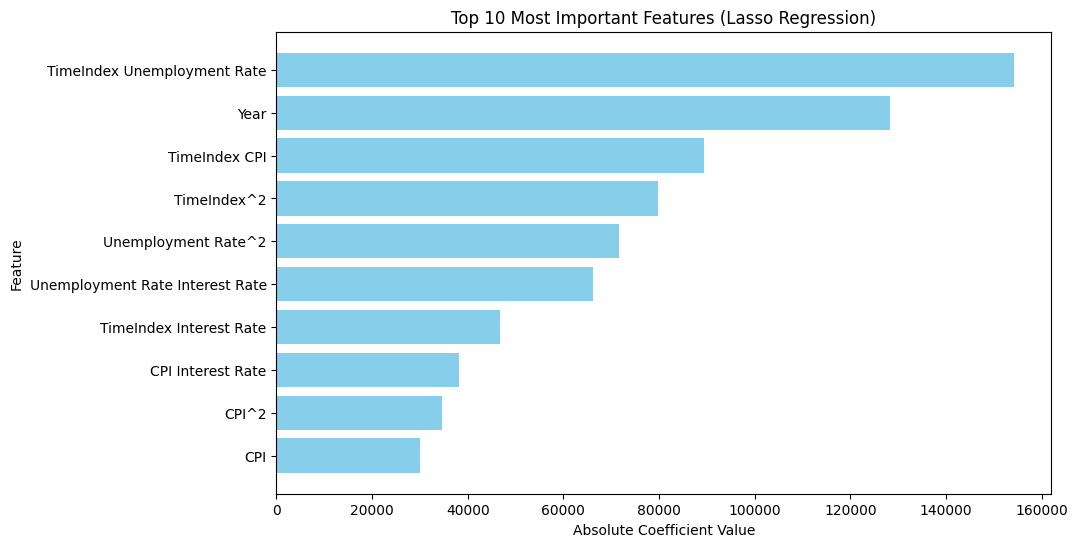

In [22]:
# Get feature names
feature_names = poly.get_feature_names_out(X_train.columns)

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 Lasso Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (Lasso Regression)')
plt.gca().invert_yaxis()
plt.show()

Ridge Regression Model

Lowest MAPE: 0.04815805234530082
Lowest Alpha: 0.25


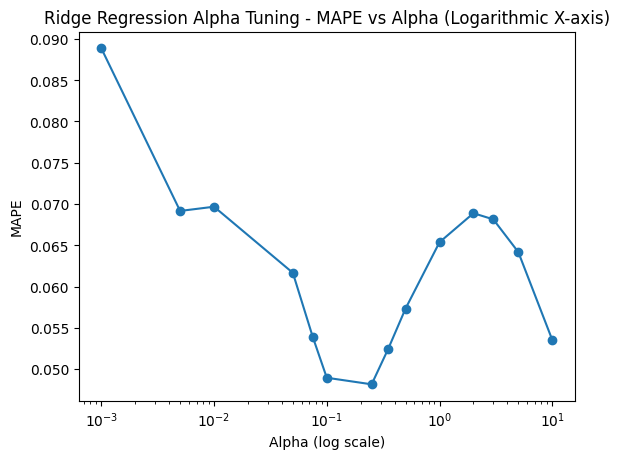



RR Root Mean Squared Error (RMSE): 34586.997710405834
RR Mean Absolute Percentage Error(MAPE): 0.04815805234530082
RR Mean Absolute Error(MAE): 28891.172716798137
R-squared(R^2): 0.846871147352243


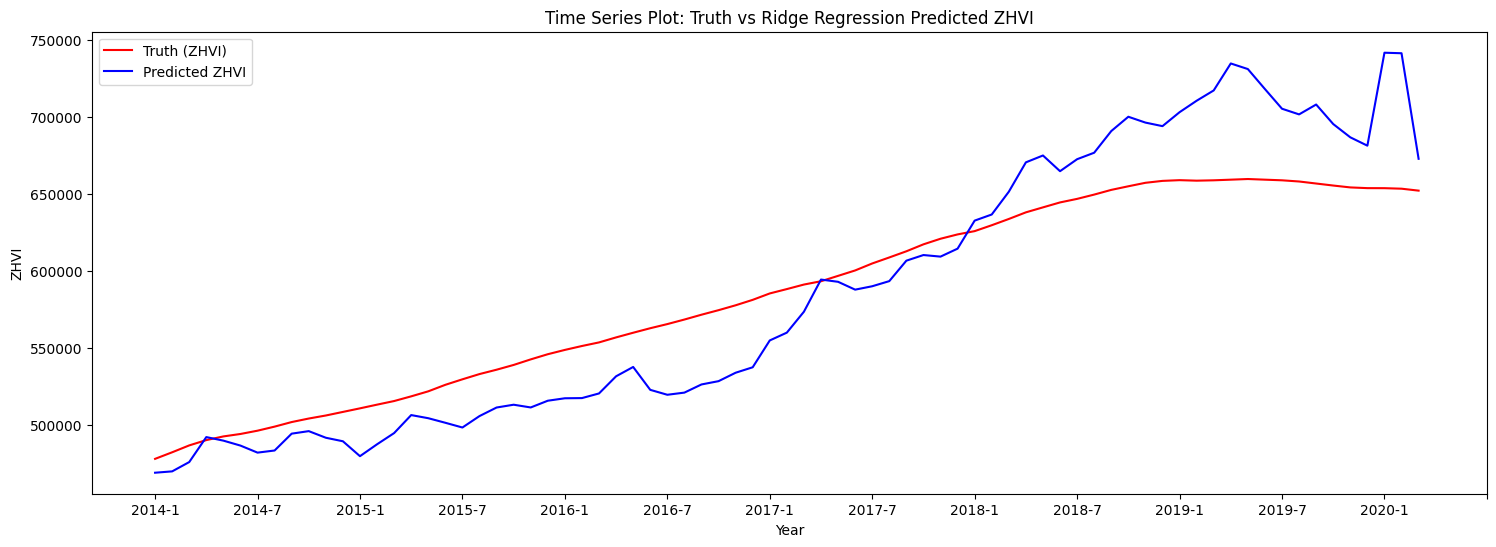

In [23]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Fit Ridge regression model
alphas = [0.001,0.005,0.01, 0.05, 0.075, 0.1, 0.25, 0.35, 0.5, 1, 2, 3, 5, 10]

lowest_alpha = alphas[0]
lowest_mape = float('inf')
results = []
for alpha in alphas:
  ridge_model = Ridge(alpha=alpha)
  ridge_model.fit(X_train_scaled, y_train)

  # Predict
  predictions = ridge_model.predict(X_test_scaled)
  test['Predicted_ZHVI'] = predictions

  # Model evaluation
  y_test = test['ZHVI']
  y_pred = test['Predicted_ZHVI']
  ridge_pred = test['Predicted_ZHVI']

  mape = mean_absolute_percentage_error(y_test, y_pred)
  results.append(mape)
  if mape < lowest_mape:
    lowest_mape = mape
    lowest_alpha = alpha

print("Lowest MAPE:", lowest_mape)
print("Lowest Alpha:", lowest_alpha)

# Plot hyperparameter tuning
plt.plot(alphas, results, marker='o')
plt.xscale('log')

plt.xlabel('Alpha (log scale)')
plt.ylabel('MAPE')
plt.title('Ridge Regression Alpha Tuning - MAPE vs Alpha (Logarithmic X-axis)')

plt.show()

alpha = lowest_alpha
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_scaled, y_train)

# Predict
predictions = ridge_model.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

# Model evaluation
y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
ridge_pred = test['Predicted_ZHVI']

ridge_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n\nRR Root Mean Squared Error (RMSE): {ridge_rmse}")
ridge_mape = mean_absolute_percentage_error(y_test, y_pred)
print("RR Mean Absolute Percentage Error(MAPE):", ridge_mape)
ridge_MAE = mean_absolute_error(y_test, y_pred)
print("RR Mean Absolute Error(MAE):", ridge_MAE)
ridge_r2 = r2_score(y_pred,y_test)
print(f"R-squared(R^2): {ridge_r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Year')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Ridge Regression Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 Ridge Regression Coefficients:
                            Feature    Coefficient  Absolute_Coefficient
22      TimeIndex Unemployment Rate -109178.576829         109178.576829
28  Unemployment Rate Interest Rate   59548.087563          59548.087563
5                               CPI   54636.320560          54636.320560
12                         Year CPI   52733.852309          52733.852309
27            Unemployment Rate CPI  -48590.347941          48590.347941
26              Unemployment Rate^2   45311.048503          45311.048503
24          TimeIndex Interest Rate   40266.286996          40266.286996
3                         TimeIndex   37172.836936          37172.836936
1                              Year   37166.437453          37166.437453
8                            Year^2   36844.519700          36844.519700


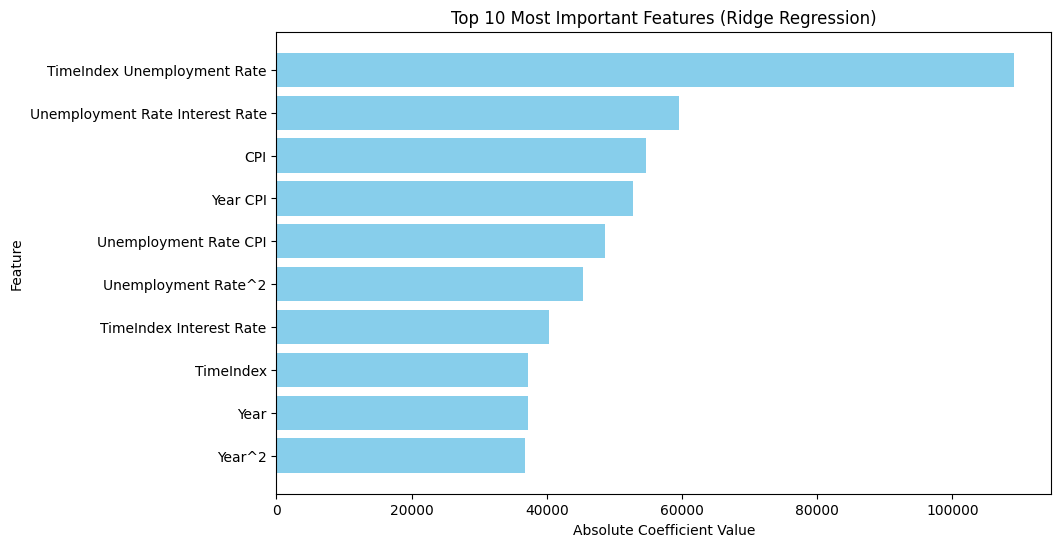

In [24]:
# Get feature names
feature_names = poly.get_feature_names_out(X_train.columns)

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_model.coef_
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 Ridge Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (Ridge Regression)')
plt.gca().invert_yaxis()
plt.show()

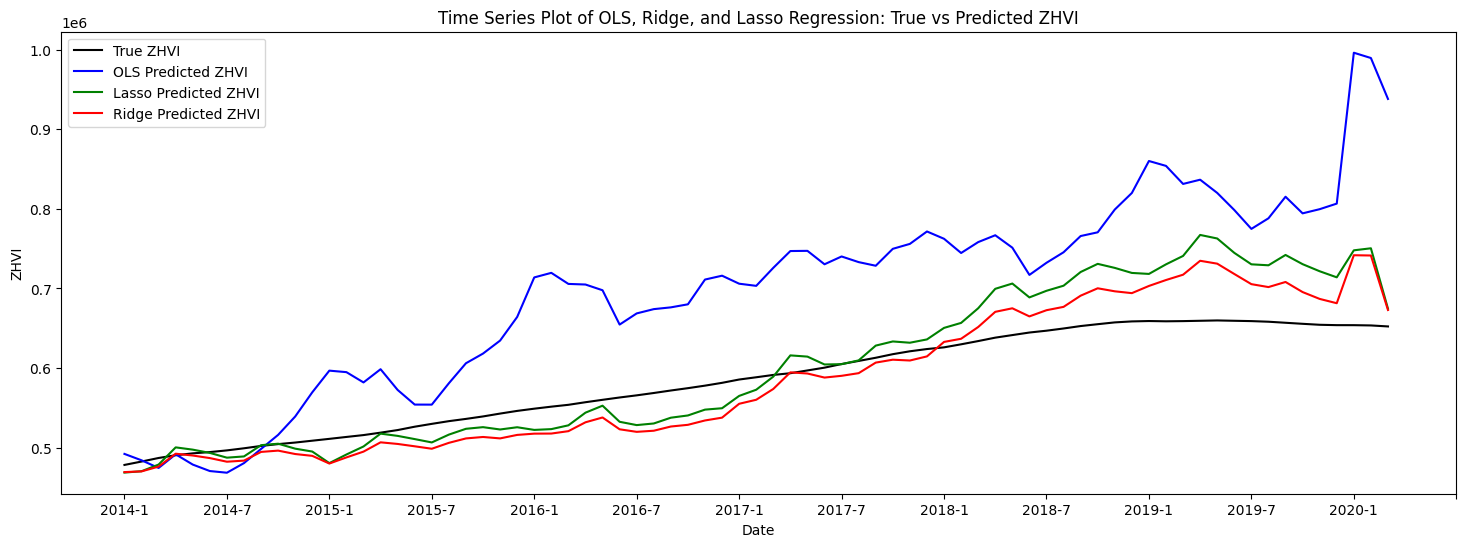

In [25]:
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='black', label='True ZHVI')
plt.plot(test['Year-Month'], OLS_pred, color='blue', label='OLS Predicted ZHVI')
plt.plot(test['Year-Month'], lasso_pred, color='green', label='Lasso Predicted ZHVI')
plt.plot(test['Year-Month'], ridge_pred, color='red', label='Ridge Predicted ZHVI')

plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot of OLS, Ridge, and Lasso Regression: True vs Predicted ZHVI')

plt.legend(loc='upper left')

plt.show()

milestone 2

In [26]:
!pip install keras-tuner
!pip install -q streamlit
!npm install localtunnel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

import tensorflow as tf
import keras_tuner as kt
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import xgboost as xgb
import statsmodels.api as sm
import joblib
import xgboost as xgb

clear_output()

DNN Model

Trial 20 Complete [00h 00m 14s]
val_loss: 3773630720.0

Best val_loss So Far: 2747978496.0
Total elapsed time: 00h 11m 01s

The hyperparameter search is complete. The optimal hyperparameters are:
- Units in first layer: 192
- Number of hidden layers: 3
- Learning rate: 0.001
- Dropout rate (first layer): 0.4

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 142135230464.0000 - mae: 357076.5938 - val_loss: 201520218112.0000 - val_mae: 448825.0938
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 137808904192.0000 - mae: 351127.2188 - val_loss: 201519529984.0000 - val_mae: 448824.3125
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 137643327488.0000 - mae: 350684.6562 - val_loss: 201518153728.0000 - val_mae: 448822.8125
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 143591079936.0000 - mae: 359643.5312 - val_loss: 201515483136.0000 - val_mae: 448819.8125
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 132160069632.0000 - mae: 343093.5000 - 

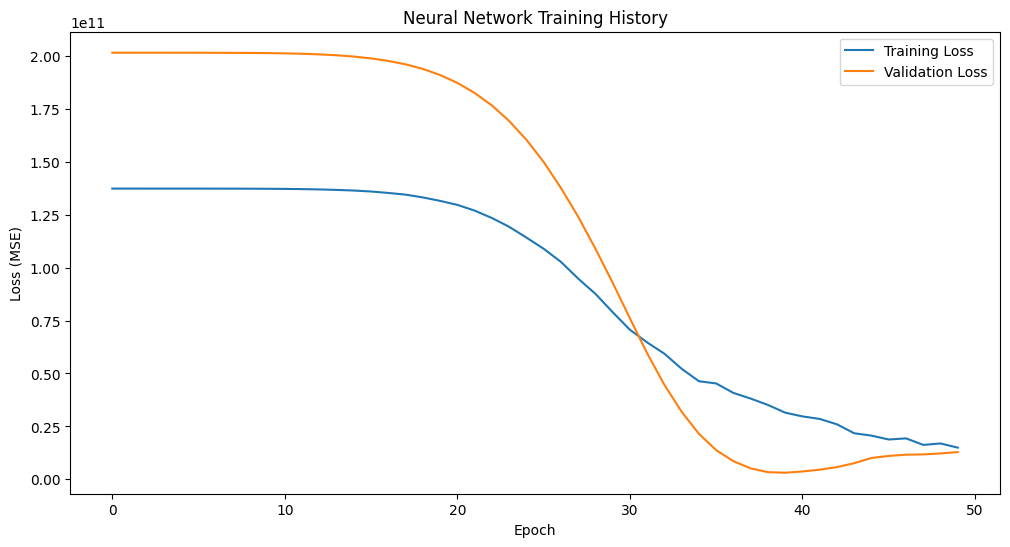

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Neural Network Root Mean Squared Error (RMSE): 96556.13473193542
Neural Network Mean Absolute Percentage Error (MAPE): 0.11076739748861884
Neural Network Mean Absolute Error (MAE): 66117.98833333333
Neural Network R-squared (R^2): -1.5689345558410244


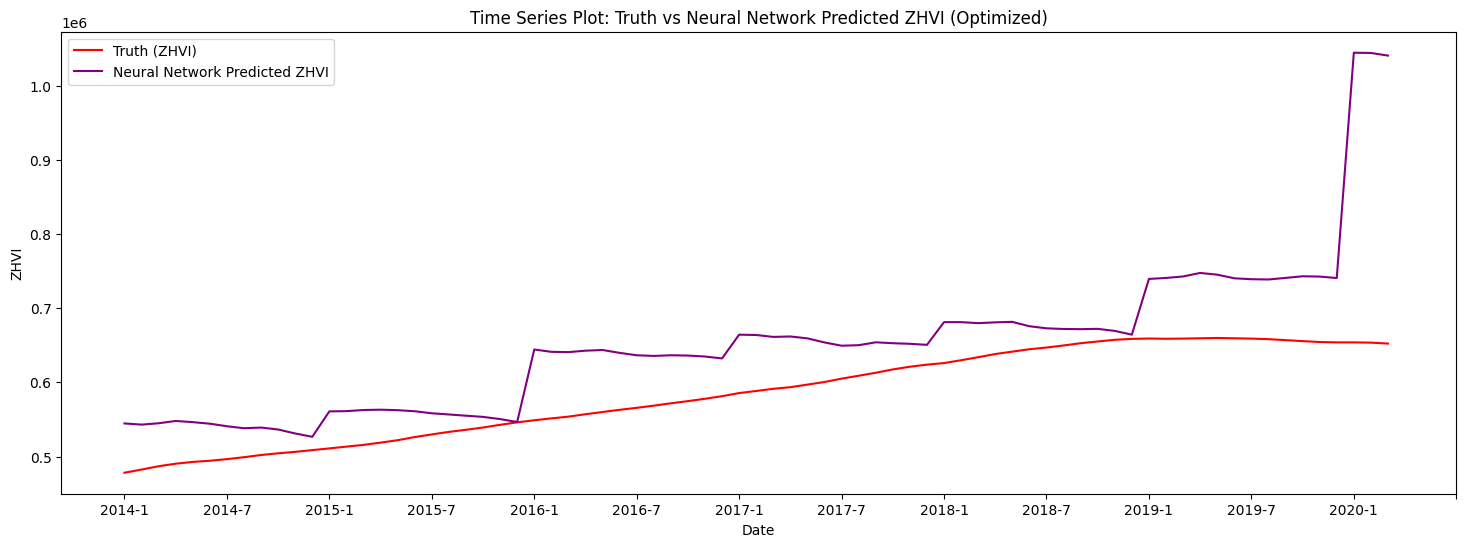

In [27]:
# Hyperparameter tuning

random.seed(158)

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model building function for Keras Tuner
def build_model(hp):

    model = Sequential()

    # Tune the number of units in the first Dense layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dropout(
        rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    ))

    # Tune the number of hidden layers (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
            activation='relu')
        )
        model.add(Dropout(
            rate=hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)
        ))

    model.add(Dense(1))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='keras_tuner',
    project_name='zhvi_prediction'
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform hyperparameter search
tuner.search(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- Units in first layer: {best_hps.get('units_1')}
- Number of hidden layers: {best_hps.get('num_layers')}
- Learning rate: {best_hps.get('learning_rate')}
- Dropout rate (first layer): {best_hps.get('dropout_1')}
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training History')
plt.legend()
plt.show()

# Predictions
nn_predictions = best_model.predict(X_test_scaled).flatten()
test['NN_Predicted_ZHVI'] = nn_predictions

# Model evaluation
nn_rmse = math.sqrt(mean_squared_error(y_test, nn_predictions))
print(f"Neural Network Root Mean Squared Error (RMSE): {nn_rmse}")
nn_mape = mean_absolute_percentage_error(y_test, nn_predictions)
print("Neural Network Mean Absolute Percentage Error (MAPE):", nn_mape)
nn_mae = mean_absolute_error(y_test, nn_predictions)
print("Neural Network Mean Absolute Error (MAE):", nn_mae)
nn_r2 = r2_score(y_test, nn_predictions)
print(f"Neural Network R-squared (R^2): {nn_r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['NN_Predicted_ZHVI'], color='purple', label='Neural Network Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Neural Network Predicted ZHVI (Optimized)')
plt.legend(loc='upper left')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Neural Network Root Mean Squared Error (RMSE): 55288.09761836565
Neural Network Mean Absolute Percentage Error (MAPE): 0.041211447799650795
Neural Network Mean Absolute Error (MAE): 25382.914583333335
Neural Network R-squared (R^2): 0.15771980293931132


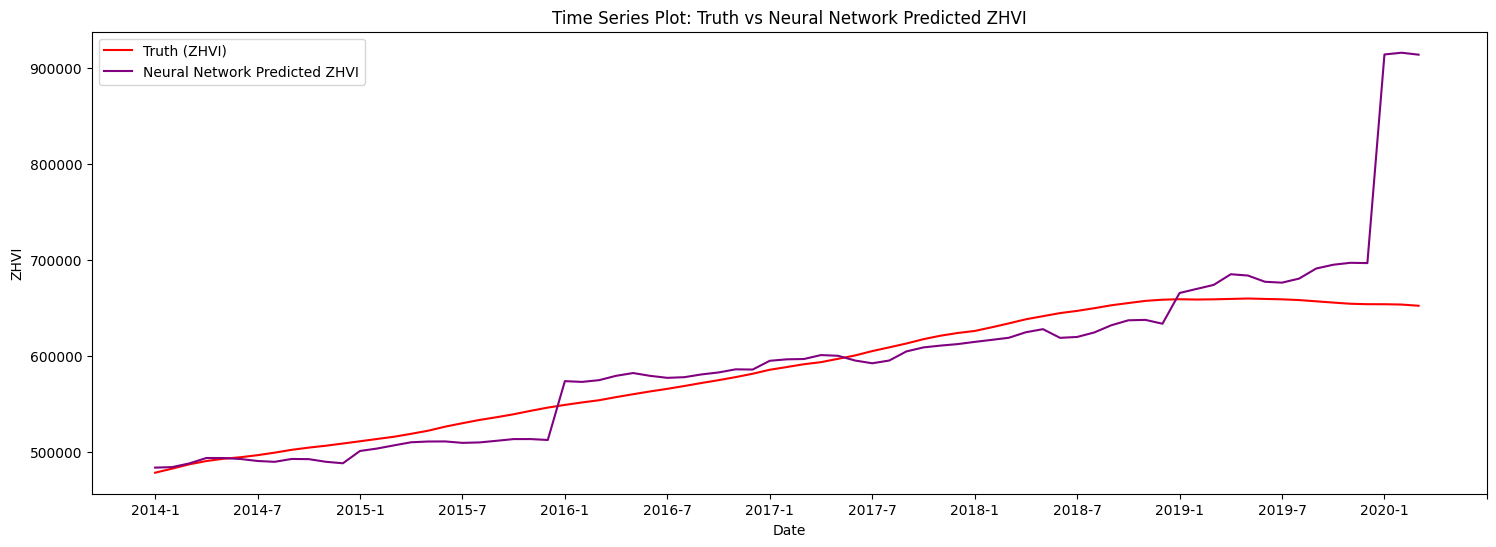

In [28]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

# Prepare test data for prediction
X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# set seed for easy reproducibility of different configurations
random.seed(158)

# preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

clear_output()

# Predictions
nn_predictions = model.predict(X_test_scaled).flatten()
test['NN_Predicted_ZHVI'] = nn_predictions

# Model evaluation
nn_rmse = math.sqrt(mean_squared_error(y_test, nn_predictions))
print(f"Neural Network Root Mean Squared Error (RMSE): {nn_rmse}")
nn_mape = mean_absolute_percentage_error(y_test, nn_predictions)
print("Neural Network Mean Absolute Percentage Error (MAPE):", nn_mape)
nn_mae = mean_absolute_error(y_test, nn_predictions)
print("Neural Network Mean Absolute Error (MAE):", nn_mae)
nn_r2 = r2_score(y_test, nn_predictions)
print(f"Neural Network R-squared (R^2): {nn_r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['NN_Predicted_ZHVI'], color='purple', label='Neural Network Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Neural Network Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Random Forest Model

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Root Mean Squared Error (RMSE): 110934.39674566274
Random Forest Mean Absolute Percentage Error (MAPE): 0.17001389114529938
Random Forest Mean Absolute Error (MAE): 102800.76702222222
Random Forest R-squared (R^2): -2.3909840626295815

Random Forest Feature Importance:
                            Feature  Importance
21                      TimeIndex^2    0.189539
23                    TimeIndex CPI    0.181033
3                         TimeIndex    0.143556
10                   Year TimeIndex    0.140208
30                            CPI^2    0.103491
12                         Year CPI    0.090341
5                               CPI    0.077447
24          TimeIndex Interest Rate    0.036600
8                            Year^2    0.010326
1                              Year    0.007912
22    

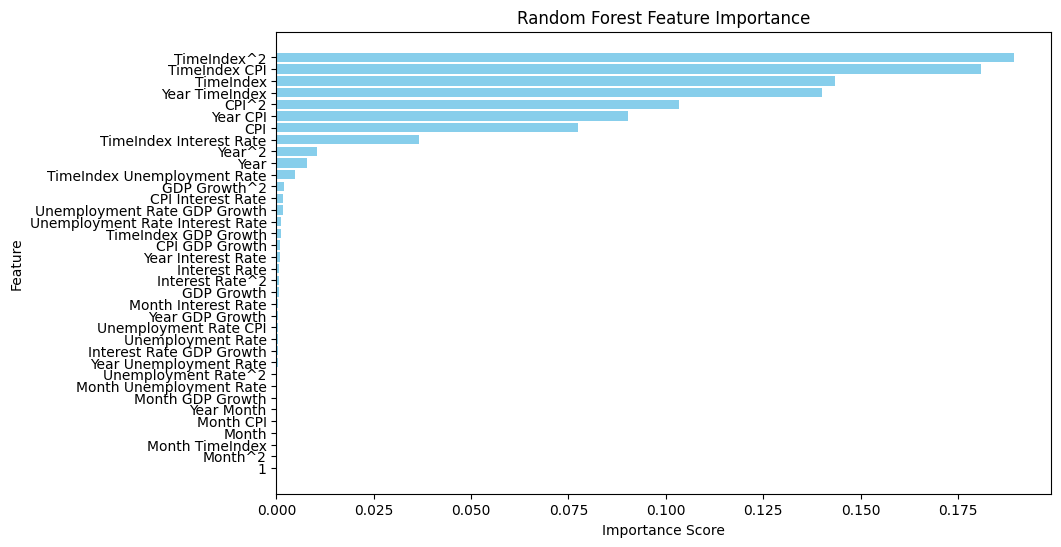

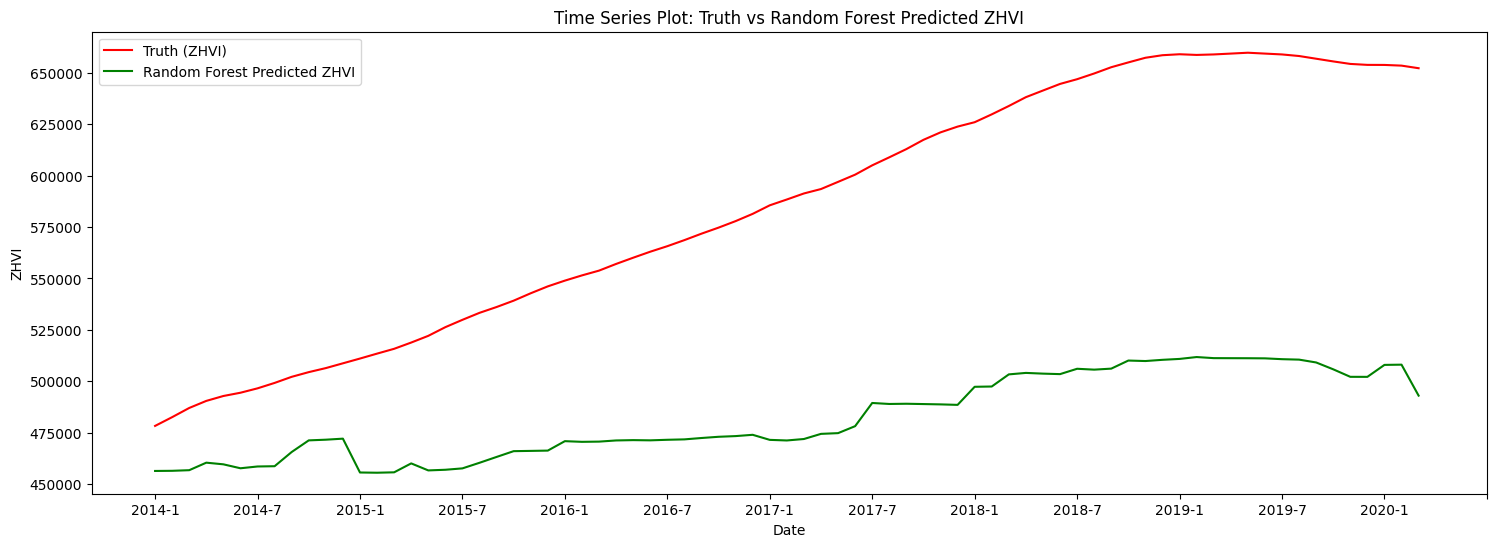

In [29]:
# Split data into training and test (same as before)
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']
X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_test = test['ZHVI']

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Get feature names from polynomial features
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f"Best Random Forest parameters: {grid_search.best_params_}")

# Predictions
rf_predictions = best_rf.predict(X_test_scaled)
test['RF_Predicted_ZHVI'] = rf_predictions

# Model evaluation
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest Root Mean Squared Error (RMSE): {rf_rmse}")
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
print("Random Forest Mean Absolute Percentage Error (MAPE):", rf_mape)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print("Random Forest Mean Absolute Error (MAE):", rf_mae)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest R-squared (R^2): {rf_r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['RF_Predicted_ZHVI'], color='green', label='Random Forest Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Random Forest Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()


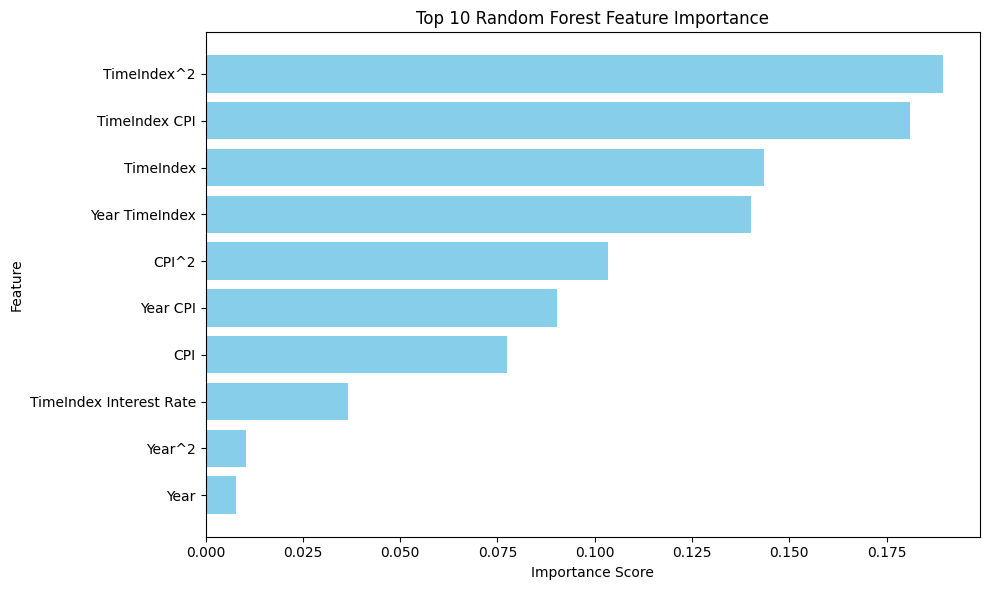

In [30]:
# Get top 10 features
top_10_features = feature_importance.head(10)

# Plot top 10 feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()  # Prevent label cutoff
plt.show()

XGBoost Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	train-rmse:97728.66420	train-mape:27.91250	test-rmse:214233.40336	test-mape:34.13594
[50]	train-rmse:1000.27290	train-mape:0.22388	test-rmse:103571.44737	test-mape:14.73869
[100]	train-rmse:172.37367	train-mape:0.03824	test-rmse:102197.62927	test-mape:14.47877
[146]	train-rmse:75.17564	train-mape:0.01729	test-rmse:102249.79864	test-mape:14.48856

Model Performance:
RMSE: 102249.7987
MAPE: 0.1449
MAE: 90674.5417
R2: -3.2301


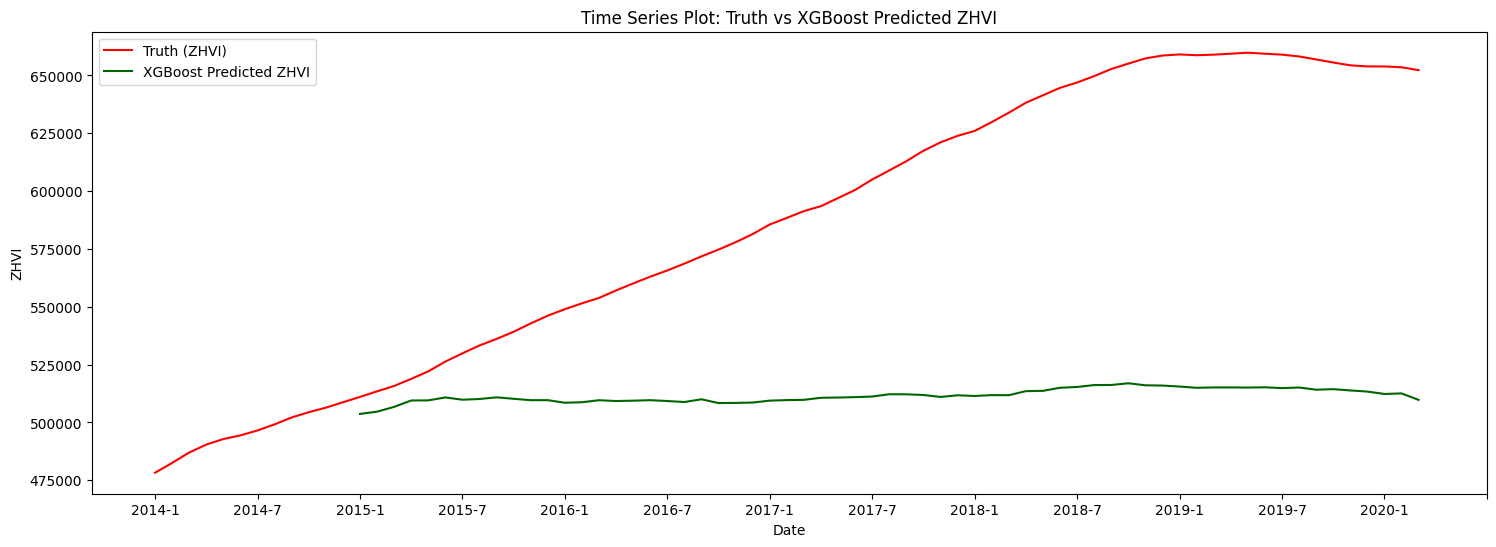

In [31]:
# Split data into training and test (same as before)
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']
X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_test = test['ZHVI']

# Feature Engineering Functions
def create_features(df, target_col='ZHVI'):
    # Create lag features
    for lag in [1, 2, 3, 6, 12]:  # Multiple time horizons
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Create rolling statistics
    for window in [3, 6, 12]:
        df[f'{target_col}_rolling_avg_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window).std()

    # Month/year indicators
    df['month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month']/12)

    return df

# Data Preparation
train = create_features(train.copy())
test = create_features(test.copy())

# Define features
base_features = ['Year', 'Month', 'TimeIndex', 'Unemployment Rate',
                'CPI', 'Interest Rate', 'GDP Growth', 'month_sin', 'month_cos']
lag_features = [col for col in train.columns if 'lag_' in col or 'rolling_' in col]
features = base_features + lag_features

# Handle missing values from lag features
X_train = train[features].dropna()
y_train = train.loc[X_train.index, 'ZHVI']
X_test = test[features].dropna()
y_test = test.loc[X_test.index, 'ZHVI']

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# XGBoost with Native API for MAPE Optimization
def xgboost_mape_train(X_train, y_train, X_test, y_test, params):
    # Convert to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Custom MAPE evaluation metric
    def mape_eval(preds, dmatrix):
        labels = dmatrix.get_label()
        return 'mape', np.mean(np.abs((labels - preds) / (labels + 1e-6))) * 100

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=50,
        feval=mape_eval,
        verbose_eval=50
    )
    return model

# Parameter Tuning with scikit-learn API
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

xgb_sklearn = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)
search = RandomizedSearchCV(
    estimator=xgb_sklearn,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_scaled, y_train)
best_params = search.best_params_

# Final Model Training with MAPE Focus
final_params = {
    **best_params,
    'objective': 'reg:squarederror',
    'seed': 158
}

# Train with native API
xgb_model = xgboost_mape_train(
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    final_params
)

# Evaluation
xgb_predictions = xgb_model.predict(xgb.DMatrix(X_test_scaled))
test.loc[X_test.index, 'XGBoost_Predicted_ZHVI'] = xgb_predictions

xgb_rmse = math.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

metrics = {
    'RMSE': xgb_rmse,
    'MAPE': xgb_mape,
    'MAE': xgb_mae,
    'R2': xgb_r2
}

print("\nModel Performance:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['XGBoost_Predicted_ZHVI'], color='darkgreen', label='XGBoost Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs XGBoost Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()


In [32]:
# Display best parameters from hyperparameter tuning
print("\nBest Hyperparameters from RandomizedSearchCV:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")


Best Hyperparameters from RandomizedSearchCV:
subsample: 0.8
min_child_weight: 1
max_depth: 5
learning_rate: 0.1
gamma: 0.2
colsample_bytree: 0.9


Comparison of Models

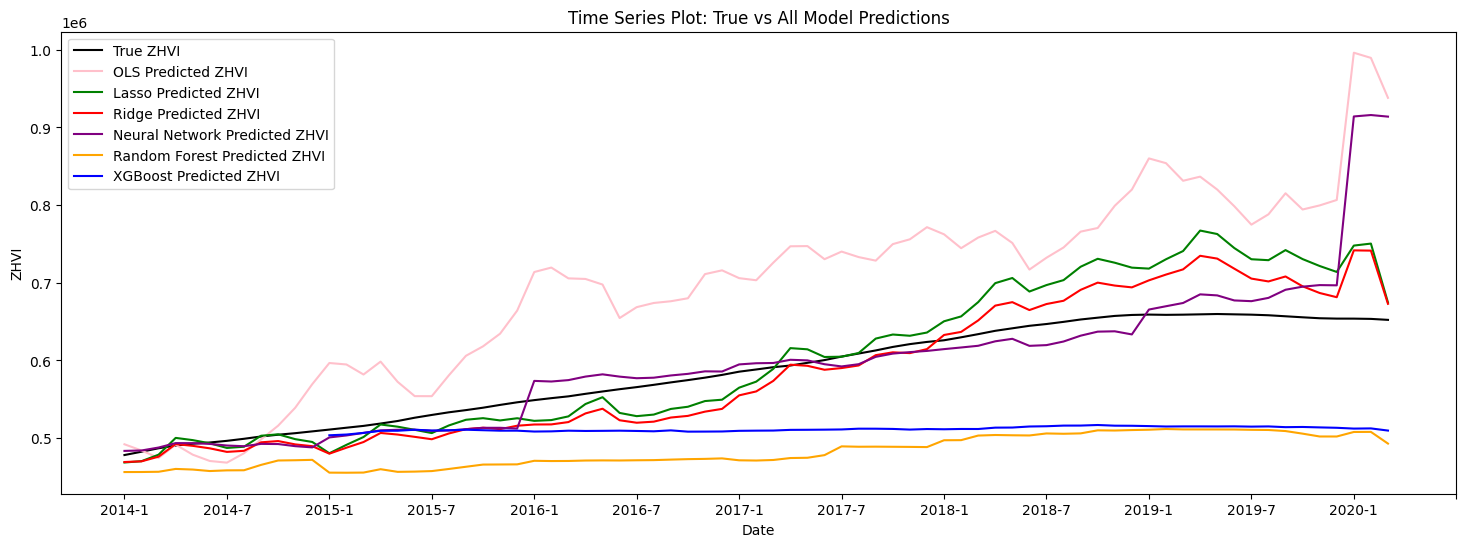


Model Performance Comparison:
            Model           RMSE      MAPE            MAE        R2
2           Ridge   34586.997710  0.048158   28891.172717  0.846871
1           Lasso   44618.016150  0.054925   34030.374730  0.785331
3  Neural Network   55288.097618  0.041211   25382.914583  0.157720
5         XGBoost  102249.798705  0.144886   90674.541667 -3.230061
4   Random Forest  110934.396746  0.170014  102800.767022 -2.390984
0             OLS  130532.096454  0.053552  112483.276028 -0.143936


In [33]:
# Combined Model Comparison Plot
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='black', label='True ZHVI')
plt.plot(test['Year-Month'], OLS_pred, color='pink', label='OLS Predicted ZHVI')
plt.plot(test['Year-Month'], lasso_pred, color='green', label='Lasso Predicted ZHVI')
plt.plot(test['Year-Month'], ridge_pred, color='red', label='Ridge Predicted ZHVI')
plt.plot(test['Year-Month'], nn_predictions, color='purple', label='Neural Network Predicted ZHVI')
plt.plot(test['Year-Month'], rf_predictions, color='orange', label='Random Forest Predicted ZHVI')
plt.plot(test['Year-Month'], test['XGBoost_Predicted_ZHVI'], color='blue', label='XGBoost Predicted ZHVI')


plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: True vs All Model Predictions')
plt.legend(loc='upper left')
plt.show()

# Model Performance Comparison Table
model_comparison = pd.DataFrame({
    'Model': ['OLS', 'Lasso', 'Ridge', 'Neural Network', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse, lasso_rmse, ridge_rmse, nn_rmse, rf_rmse, xgb_rmse],
    'MAPE': [mape, lasso_mape, ridge_mape, nn_mape, rf_mape, xgb_mape],
    'MAE': [MAE, lasso_MAE, ridge_MAE, nn_mae, rf_mae, xgb_mae],
    'R2': [r2, lasso_r2, ridge_r2, nn_r2, rf_r2, xgb_r2]
})

print("\nModel Performance Comparison:")
print(model_comparison.sort_values('RMSE'))

Ensemble Model

In [34]:
# ensemble model
original_features = ['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']

# add polynomial features and scaling
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train[original_features])
X_test_poly = poly.transform(X_test[original_features])

print("Number of polynomial features:", X_train_poly.shape[1])

X_train_poly = np.column_stack([np.ones(X_train_poly.shape[0]), X_train_poly])  # Add bias column
X_test_poly = np.column_stack([np.ones(X_test_poly.shape[0]), X_test_poly])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)


# model dictionary for ensemble
trained_models = {
    'Lasso': lasso_model,
    'Ridge': ridge_model,
    'Random Forest': best_rf,
    'XGBoost': xgb_model
}

# Prediction function
def get_predictions(model, X, model_type):
    if model_type in ['Lasso', 'Ridge', 'Random Forest']:
        if hasattr(model, 'n_features_in_'):
            if X.shape[1] != model.n_features_in_:
                raise ValueError(f"Feature mismatch! Model expects {model.n_features_in_} features but got {X.shape[1]}")

    if model_type == 'XGBoost':
        return model.predict(xgb.DMatrix(X))
    elif model_type == 'Neural Network':
        return model.predict(X).flatten()
    else:
        return model.predict(X)


# Generate predictions
predictions_train = {name: get_predictions(model, X_train_scaled, name)
                    for name, model in trained_models.items()}
predictions_test = {name: get_predictions(model, X_test_scaled, name)
                   for name, model in trained_models.items()}

# Create ensemble DataFrames
ensemble_train = pd.DataFrame(predictions_train)
ensemble_test = pd.DataFrame(predictions_test)
ensemble_train['True_ZHVI'] = y_train.values
ensemble_test['True_ZHVI'] = y_test.values

def evaluate_predictions(name, y_true, y_pred):
    return {
        'Model': name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'R2': r2_score(y_true, y_pred)
    }

# Ensemble Comparison
print("\n Ensemble Comparison")

# Evaluate ensemble methods
ensemble_results = []

# Simple Average Ensemble
simple_avg = ensemble_test.drop(columns=['True_ZHVI']).mean(axis=1)
ensemble_results.append(evaluate_predictions(
    'Simple Average', y_test, simple_avg
))

# Weighted Average Ensemble (weighted by inverse MAE)
model_weights = {m: 1/mean_absolute_error(y_test, ensemble_test[m])
                for m in trained_models}
total_weight = sum(model_weights.values())
weighted_avg = sum(ensemble_test[m]*(w/total_weight) for m,w in model_weights.items())
ensemble_results.append(evaluate_predictions(
    'Weighted Average', y_test, weighted_avg
))

# Stacking Ensemble
predictions_train = {name: get_predictions(model, X_train_scaled, name)
                    for name, model in trained_models.items()}

meta_model = LinearRegression()
meta_model.fit(ensemble_train.drop(columns=['True_ZHVI']), ensemble_train['True_ZHVI'])
stacking_pred = meta_model.predict(ensemble_test.drop(columns=['True_ZHVI']))
ensemble_results.append(evaluate_predictions(
    'Stacking Ensemble', y_test, stacking_pred
))

# Create comparison DataFrame
ensemble_comparison = pd.DataFrame(ensemble_results)
ensemble_comparison.sort_values('MAPE', inplace=True)

# Format for display
display_df = ensemble_comparison.copy()
for col in ['MAE', 'RMSE']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:,.2f}")
display_df['MAPE'] = display_df['MAPE'].apply(lambda x: f"{x:.2f}%")
display_df['R2'] = display_df['R2'].apply(lambda x: f"{x:.4f}")

print("\nEnsemble Methods Performance (Sorted by MAPE):")
print(tabulate(display_df[['Model', 'MAE', 'RMSE', 'MAPE', 'R2']],
               headers='keys', tablefmt='psql', showindex=False))

# Best ensemble method
best_ensemble = ensemble_comparison.iloc[0]
print(f"\nBest Performing Ensemble Method: {best_ensemble['Model']}")
print(f"- MAE: {best_ensemble['MAE']:,.2f}")
print(f"- RMSE: {best_ensemble['RMSE']:,.2f}")
print(f"- MAPE: {best_ensemble['MAPE']:.2f}%")
print(f"- R2: {best_ensemble['R2']:.4f}")

# Save the complete ensemble model
ensemble_package = {
            'base_models': {name: model for name, model in trained_models.items() if name in predictions_train},
            'meta_model': meta_model,
            'poly': poly,
            'scaler': scaler,
            'feature_names': original_features,
            'get_predictions': get_predictions
        }

joblib.dump(ensemble_package, 'final_zhvi_ensemble_model.pkl')

Number of polynomial features: 35

 Ensemble Comparison

Ensemble Methods Performance (Sorted by MAPE):
+-------------------+-----------+-----------+--------+---------+
| Model             | MAE       | RMSE      | MAPE   |      R2 |
|-------------------+-----------+-----------+--------+---------|
| Weighted Average  | 21,694.88 | 24,867.89 | 3.69%  |  0.7498 |
| Simple Average    | 38,783.54 | 40,336.11 | 6.47%  |  0.3417 |
| Stacking Ensemble | 94,035.58 | 96,290.63 | 15.44% | -2.7514 |
+-------------------+-----------+-----------+--------+---------+

Best Performing Ensemble Method: Weighted Average
- MAE: 21,694.88
- RMSE: 24,867.89
- MAPE: 3.69%
- R2: 0.7498


['final_zhvi_ensemble_model.pkl']

Model Comparison


Model Performance Comparison (Sorted by MAPE):
+-------------------+------------+------------+--------+---------+
| Model             | MAE        | RMSE       | MAPE   |      R2 |
|-------------------+------------+------------+--------+---------|
| Weighted Average  | 21,694.88  | 24,867.89  | 3.69%  |  0.7498 |
| Neural Network    | 25,382.91  | 55,288.10  | 4.12%  |  0.1577 |
| Ridge             | 28,891.17  | 34,587.00  | 4.82%  |  0.8469 |
| OLS               | 112,483.28 | 130,532.10 | 5.36%  | -0.1439 |
| Lasso             | 34,030.37  | 44,618.02  | 5.49%  |  0.7853 |
| Simple Average    | 38,783.54  | 40,336.11  | 6.47%  |  0.3417 |
| XGBoost           | 90,674.54  | 102,249.80 | 14.49% | -3.2301 |
| Stacking Ensemble | 94,035.58  | 96,290.63  | 15.44% | -2.7514 |
| Random Forest     | 102,800.77 | 110,934.40 | 17.00% | -2.391  |
+-------------------+------------+------------+--------+---------+


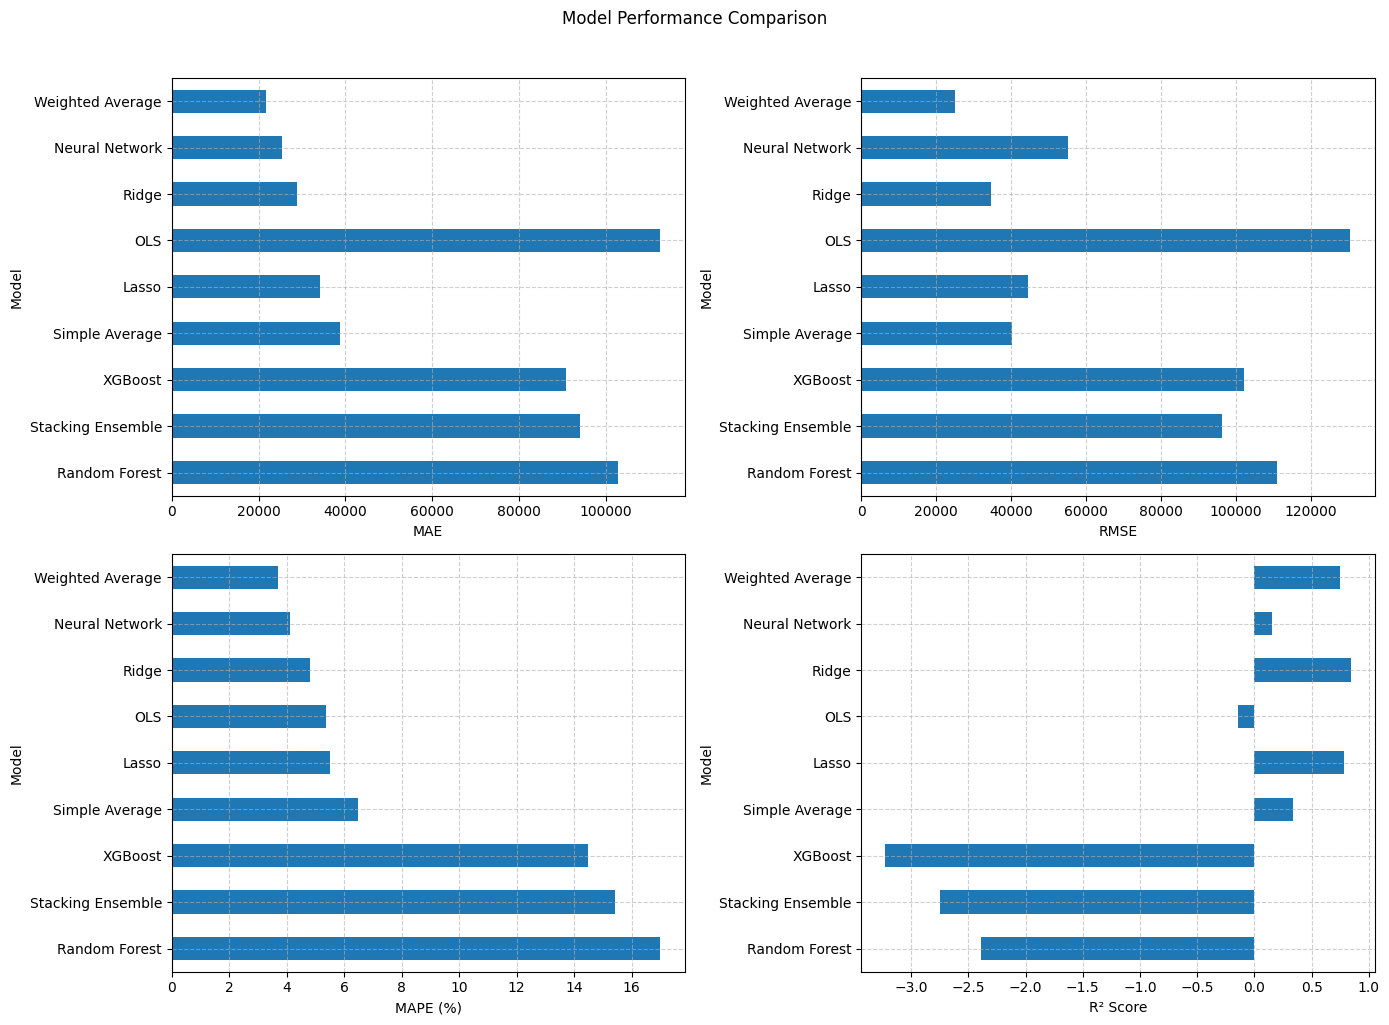


Best Performing Model: Weighted Average
- MAE: 21,694.88
- RMSE: 24,867.89
- MAPE: 3.69%
- R2: 0.7498


In [35]:
# Create and display comparison
comparison_df = pd.DataFrame(ensemble_comparison)
comparison_df.loc[3] = ['OLS', MAE, rmse, mape*100, r2]
comparison_df.loc[4] = ['Ridge', ridge_MAE, ridge_rmse, ridge_mape*100, ridge_r2]
comparison_df.loc[5] = ['Lasso', lasso_MAE, lasso_rmse, lasso_mape*100, lasso_r2]
comparison_df.loc[6] = ['Random Forest', rf_mae, rf_rmse, rf_mape*100, rf_r2]
comparison_df.loc[7] = ['Neural Network', nn_mae, nn_rmse, nn_mape*100, nn_r2]
comparison_df.loc[8] = ['XGBoost', xgb_mae, xgb_rmse, xgb_mape*100, xgb_r2]

comparison_df.sort_values('MAPE', inplace=True)

# Format for display
display_df = comparison_df.copy()
for col in ['MAE', 'RMSE']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:,.2f}")
display_df['MAPE'] = display_df['MAPE'].apply(lambda x: f"{x:.2f}%")
display_df['R2'] = display_df['R2'].apply(lambda x: f"{x:.4f}")

print("\nModel Performance Comparison (Sorted by MAPE):")
print(tabulate(display_df[['Model', 'MAE', 'RMSE', 'MAPE', 'R2']],
               headers='keys', tablefmt='psql', showindex=False))

# Visualization
metrics = ['MAE', 'RMSE', 'MAPE', 'R2']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', y=1.02)

for ax, metric in zip(axes.flatten(), metrics):
    if metric == 'MAPE':
        comparison_df.plot.barh(x='Model', y=metric, ax=ax, legend=False)
        ax.set_xlabel('MAPE (%)')
    elif metric == 'R2':
        comparison_df.plot.barh(x='Model', y=metric, ax=ax, legend=False)
        ax.set_xlabel('R² Score')
    else:
        comparison_df.plot.barh(x='Model', y=metric, ax=ax, legend=False)
        ax.set_xlabel(metric)

    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Best model summary
best_model = comparison_df.iloc[0]
print(f"\nBest Performing Model: {best_model['Model']}")
print(f"- MAE: {best_model['MAE']:,.2f}")
print(f"- RMSE: {best_model['RMSE']:,.2f}")
print(f"- MAPE: {best_model['MAPE']:.2f}%")
print(f"- R2: {best_model['R2']:.4f}")

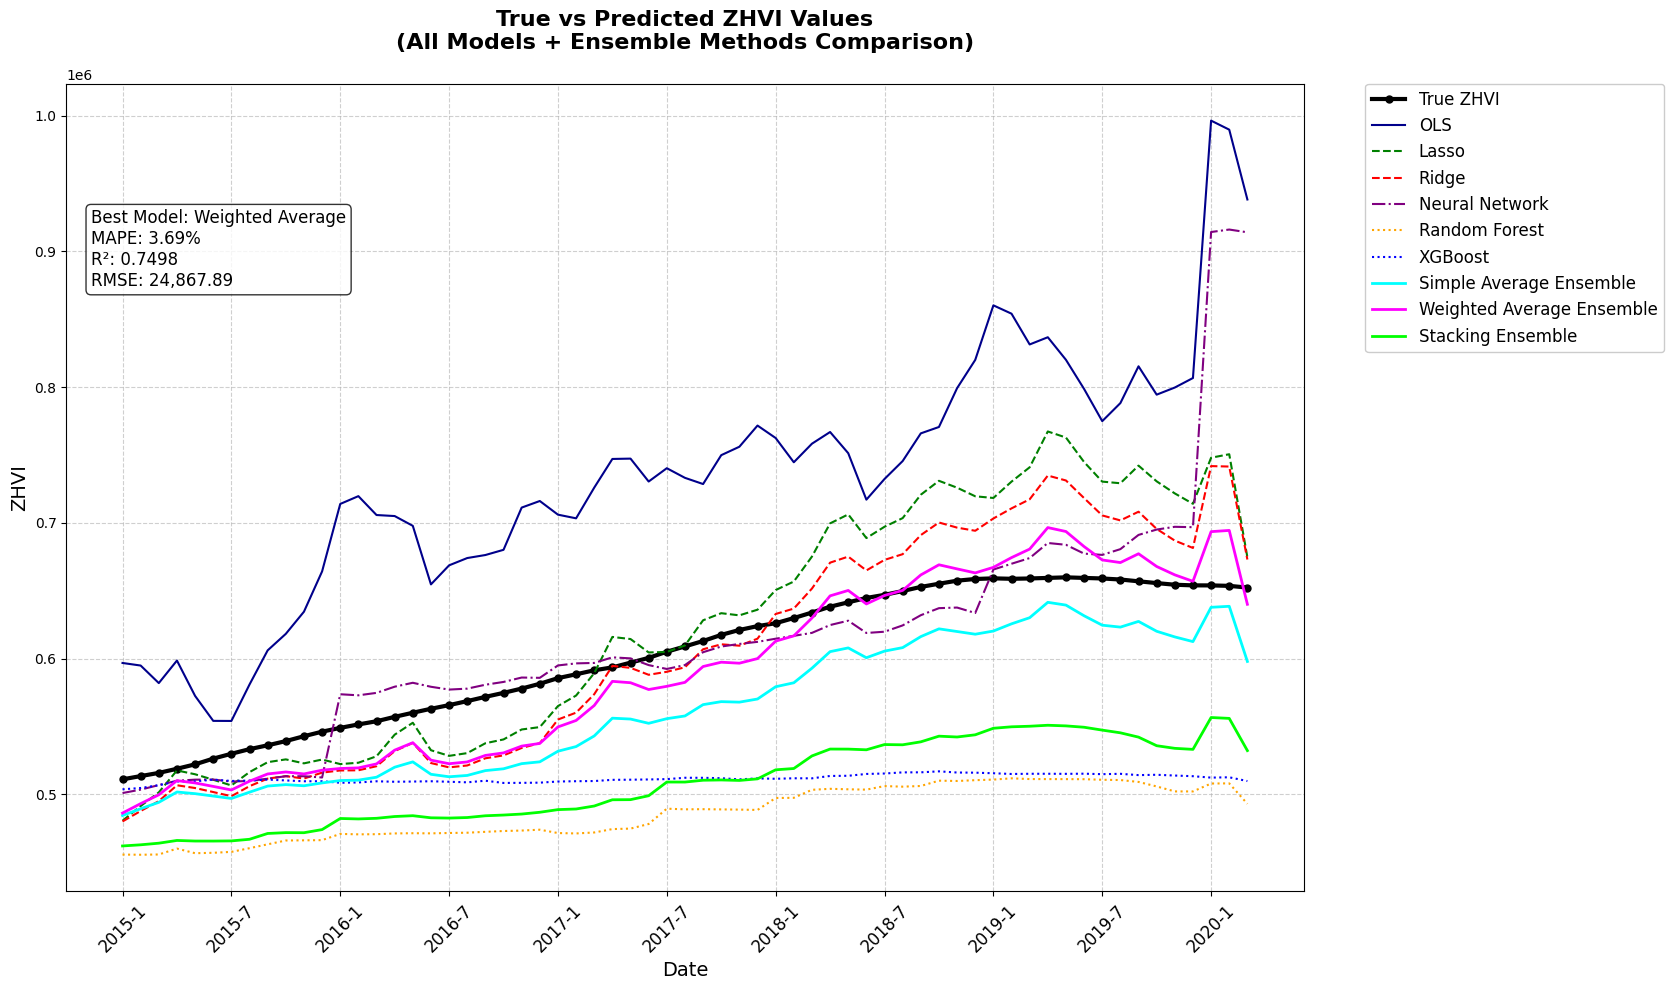

In [37]:
valid_test_indices = ensemble_test.index + 12
valid_dates = test['Year-Month'].iloc[valid_test_indices]

# Set up the plot
plt.figure(figsize=(20, 10))  # Slightly taller figure

# Plot - keeping your original styling
plt.plot(valid_dates, test['ZHVI'].iloc[valid_test_indices], color='black', linewidth=3, label='True ZHVI', marker='o', markersize=5)
plt.plot(valid_dates, OLS_pred.iloc[valid_test_indices], color='darkblue', linestyle='-', label='OLS')
plt.plot(valid_dates, lasso_pred.iloc[valid_test_indices], color='green', linestyle='--', label='Lasso')
plt.plot(valid_dates, ridge_pred.iloc[valid_test_indices], color='red', linestyle='--', label='Ridge')
plt.plot(valid_dates, nn_predictions[valid_test_indices], color='purple', linestyle='-.', label='Neural Network')
plt.plot(valid_dates, rf_predictions[valid_test_indices], color='orange', linestyle=':', label='Random Forest')
plt.plot(valid_dates, test['XGBoost_Predicted_ZHVI'].iloc[valid_test_indices], color='blue', linestyle=':', label='XGBoost')
plt.plot(valid_dates, simple_avg, color='cyan', linewidth=2, linestyle='-', label='Simple Average Ensemble')
plt.plot(valid_dates, weighted_avg, color='magenta', linewidth=2, linestyle='-', label='Weighted Average Ensemble')
plt.plot(valid_dates, stacking_pred, color='lime', linewidth=2, linestyle='-', label='Stacking Ensemble')

# Formatting
plt.xlabel('Date', fontsize=14)  # Increased font size
plt.ylabel('ZHVI', fontsize=14)  # Increased font size
plt.title('True vs Predicted ZHVI Values\n(All Models + Ensemble Methods Comparison)',
          fontsize=16, pad=25, weight='bold')  # Bigger and bold title
x_ticks = np.arange(0, len(valid_dates), 6)
plt.xticks(x_ticks, valid_dates.iloc[x_ticks], rotation=45, fontsize=12)  # Bigger x-tick labels

# Add grid and legend with larger font
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
           prop={'size': 12}, framealpha=1)  # Bigger legend with solid background

# Add performance metrics annotation with bigger font
metrics_text = (
    f"Best Model: {best_ensemble['Model']}\n"
    f"MAPE: {best_ensemble['MAPE']:.2f}%\n"
    f"R²: {best_ensemble['R2']:.4f}\n"
    f"RMSE: {best_ensemble['RMSE']:,.2f}"
)
plt.annotate(metrics_text, xy=(0.02, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=12)  # Bigger annotation text

# Adjust layout to accommodate larger elements
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend on right

plt.savefig('model_comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()